In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import shutil
import string
import re

# Making sure tensorflow is working properly
print("TensorFlow Versions: ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

# This prevents some error messages caused by reaching memory limits
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow Versions:  2.7.0
TensorFlow **IS** using the GPU


In [2]:
data_dir = pathlib.Path('/home/addy/.keras/datasets')/'aclImdb'

if data_dir.exists():
    print("Found the 'aclImdb' dataset.")

else:
    print("Downloading 'aclImdb' dataset.")
    
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True)

    data_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    unsup = data_dir/ 'train' / 'unsup'
    if unsup.exists():
        print("Deleting unsupervised texts.")
        shutil.rmtree(unsup)


Found the 'aclImdb' dataset.


In [3]:
train_dir = data_dir / 'train'
os.listdir(train_dir)


['urls_pos.txt',
 'pos',
 'neg',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_unsup.txt',
 'labeledBow.feat']

In [4]:
pos_count = len(list(data_dir.glob('train/pos/*.txt')))
neg_count = len(list(data_dir.glob('train/neg/*.txt')))
all_count = neg_count + pos_count
print("Data Directory: ", data_dir)
print("Number of texts in train: ", all_count)
print("Number of texts in train/pos/: ", pos_count)
print("Number of texts in train/neg/: ", neg_count)
print()
pos_count = len(list(data_dir.glob('test/pos/*.txt')))
neg_count = len(list(data_dir.glob('test/neg/*.txt')))
all_count = neg_count + pos_count
print("Number of texts in test: ", all_count)
print("Number of texts in test/pos/: ", pos_count)
print("Number of texts in test/neg/: ", neg_count)

Data Directory:  /home/addy/.keras/datasets/aclImdb
Number of texts in train:  25000
Number of texts in train/pos/:  12500
Number of texts in train/neg/:  12500

Number of texts in test:  25000
Number of texts in test/pos/:  12500
Number of texts in test/neg/:  12500


In [5]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

epochs = 10         # The number of training epochs

In [6]:
# Initializing the training dataset

train_ds = tf.keras.utils.text_dataset_from_directory(
  data_dir/'train',
  validation_split=0.2,
  subset="training",
  seed=seed,
  batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-01-02 13:54:17.170298: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-02 13:54:17.579191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3823 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [9]:
class_names = train_ds.class_names

for text_batch, label_batch in train_ds.take(1):
  print('texts: ', text_batch.numpy()[:3])
  print()
  print('labels: ', label_batch.numpy()[:3])



texts:  [b"I am a big movie fan. I like movies of all types. This is arguably the worst movie I've ever seen.<br /><br />I get that it follows the book closely, which raises the point that not everything should be made into a movie. Especially since the authenticity of the experiences in the book have been called into question more than once.<br /><br />These characters are not quirky, they are mentally ill. The things that happen are not funny, they are disturbing; especially considering they are supposed to be true.<br /><br />This movie had the feel of The Royal Tenenbaums, another movie I hated, only Running With Scissors was even more dysfunctional and less funny.<br /><br />I will never get those hours back. I wanted to wash my brain after watching."
 b'As a grownup in my mid-40s, I am not even close to any of "Nancy Drew"\'s key demographics, but I was pleasantly surprised by the film this afternoon; so, I could tell, were the pair of sixtyish silver-haired ladies down the row f

In [10]:
# Initializing the validation dataset

val_ds = tf.keras.utils.text_dataset_from_directory(
  data_dir/'train',
  validation_split=0.2,
  subset="validation",
  seed=seed,
  batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    data_dir/'test', 
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


In [12]:
'[%s]' % re.escape(string.punctuation)

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]'

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [14]:
text = 'I can\'t believe this movie managed to get such a relatively high rating of 6! It is barely watchable and unbelievably boring, certainly one of the worst films I have seen in a long, long time.<br /><br />In a no-budget way, it reminded me of Star Wars Episodes I and II for the sheer impression that you are watching a total creative train wreck.<br /><br />This film should be avoided at all costs. It\'s one of those "festival films" that only please the pseudo-intellectuals because they are so badly made those people think it makes it "different", therefore good.<br /><br />Bad film-making is not "different", it\'s just bad film-making.'

In [15]:
custom_standardization(text)

<tf.Tensor: shape=(), dtype=string, numpy=b'i cant believe this movie managed to get such a relatively high rating of 6 it is barely watchable and unbelievably boring certainly one of the worst films i have seen in a long long time  in a nobudget way it reminded me of star wars episodes i and ii for the sheer impression that you are watching a total creative train wreck  this film should be avoided at all costs its one of those festival films that only please the pseudointellectuals because they are so badly made those people think it makes it different therefore good  bad filmmaking is not different its just bad filmmaking'>

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [17]:
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [17]:
vectorize_layer("Hello There")

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([4749,   46,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [18]:
vectorize_layer.get_vocabulary()[4749], vectorize_layer.get_vocabulary()[46] 

('hello', 'there')

In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [21]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film'],
      dtype='<U17')

In [23]:
encoded_example = vectorize_layer(text_batch)[:3].numpy()
for n in range(2):
  print("Original: ", text_batch[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()


Original:  b"I am a big movie fan. I like movies of all types. This is arguably the worst movie I've ever seen.<br /><br />I get that it follows the book closely, which raises the point that not everything should be made into a movie. Especially since the authenticity of the experiences in the book have been called into question more than once.<br /><br />These characters are not quirky, they are mentally ill. The things that happen are not funny, they are disturbing; especially considering they are supposed to be true.<br /><br />This movie had the feel of The Royal Tenenbaums, another movie I hated, only Running With Scissors was even more dysfunctional and less funny.<br /><br />I will never get those hours back. I wanted to wash my brain after watching."
Round-trip:  i am a big movie fan i like movies of all types this is arguably the worst movie ive ever seen i get that it follows the book closely which raises the point that not everything should be made into a movie especially si

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [25]:
embedding_dim = 16

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(max_features + 1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 16)           160016    
                                                                 
 dropout (Dropout)           (None, 250, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [26]:

# Choosing the tf.keras.optimizers.Adam with 
# the tf.keras.losses.BinaryCrossentropy loss function and
# the tf.metrics.BinaryAccuracy as metric

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Finally fitting the model to the data in train_ds 
# with val_ds as the validation dataset
# running for 10 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6636 - binary_accuracy: 0.7016 - val_loss: 0.6133 - val_binary_accuracy: 0.7730
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5480 - binary_accuracy: 0.8015 - val_loss: 0.4971 - val_binary_accuracy: 0.8202
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4438 - binary_accuracy: 0.8453 - val_loss: 0.4210 - val_binary_accuracy: 0.8454
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3770 - binary_accuracy: 0.8669 - val_loss: 0.3765 - val_binary_accuracy: 0.8572
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3346 - binary_accuracy: 0.8784 - val_loss: 0.3489 - val_binary_accuracy: 0.8650
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3041 - binary_accuracy: 0.8907 - val_loss: 0.3303 - val_binary_accuracy: 0.8696
Epoch 7/10
625/625 [==============================] - 2s 4ms/ste

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


782/782 [==============================] - 2s 2ms/step - loss: 0.3099 - binary_accuracy: 0.8726
Loss:  0.3098743259906769
Accuracy:  0.8726400136947632


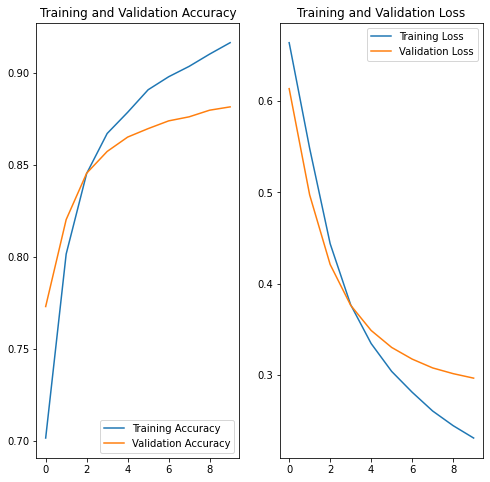

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


157/157 [==============================] - 0s 2ms/step


(array([1357.,  390.,  258.,  212.,  193.,  180.,  219.,  294.,  439.,
        1458.]),
 array([2.2010074e-06, 9.9999681e-02, 1.9999716e-01, 2.9999465e-01,
        3.9999211e-01, 4.9998960e-01, 5.9998709e-01, 6.9998455e-01,
        7.9998201e-01, 8.9997953e-01, 9.9997699e-01], dtype=float32),
 <BarContainer object of 10 artists>)

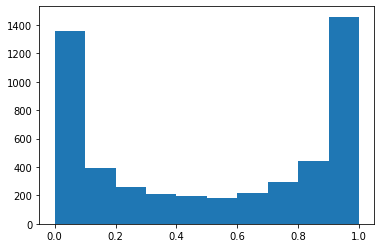

In [29]:
predictions = model.predict(val_ds, verbose=1)

predictions = tf.squeeze(predictions)

predictions = tf.math.sigmoid(predictions)

plt.hist(predictions.numpy())

In [30]:
def getItemsFromDataset(dataset):
    items = np.asarray([i for x,y in dataset for i in x.numpy()])
    labels = np.asarray([i for x,y in dataset for i in y.numpy()])
    return items, labels

In [31]:
test_texts, test_labels = getItemsFromDataset(val_ds)

In [38]:
true_predictions = tf.equal(tf.round(predictions),tf.convert_to_tensor(test_labels, dtype=tf.float32)).numpy()

In [44]:
count = 0
for index, val in enumerate(true_predictions):
    if not val:
        print(f"Positive with {predictions[index]}% :", test_texts[index])
        print()
        count += 1
        if count > 5:
            break

Positive with 0.7326981425285339% : b"A few years back the same persons who created Paris,J'TAIME., which was imperfect but very enjoyable ( my rating was a 7), created this piece of garbage about New York City.<br /><br />In Paris, I Love You (J'taime)created a feeling for Paris & it was made in many parts of beautiful Paris.<br /><br />In this current film, I did not recognize New York City, I did not feel that I was in the city of my birth.<br /><br />New York does have 5 boroughs,I saw no scenes in The Bronx, or Queens ,There is one scene in Brooklyn,(Brighton Beach), I saw no scenes in Times Square or Greenwich Village/ No scenes of the beautiful hotels or theatres. It does have a large cast,most of the performers were not even stereotypes, they were caricatures of the lowest sort.<br /><br />The very few humorous moments are all of a course sexual nature or quite insulting to the many fine New Yorkers that we all know & love.. <br /><br />A few of the films nominated for the 'raz